<a href="https://colab.research.google.com/github/PraneelUJ/CS203_Lab_5/blob/main/task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Group 23

*   Sonawane Samarth - 23110317
*   Praneel Joshi - 23110254


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from transformers import AutoImageProcessor, ResNetConfig, ResNetForImageClassification
import torch
import os
import random

In [ ]:
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets
import torch.optim as optim
import torch.nn as nn

## Model on original dataset

In [ ]:
# Dataset paths
data_dir = "/content/drive/MyDrive/dataset"

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224 input
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard ResNet normalization
])

In [ ]:
# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

cat_indices = [i for i in range(len(dataset)) if dataset.imgs[i][1] == 0]  # All cat indices
dog_indices = [i for i in range(len(dataset)) if dataset.imgs[i][1] == 1]  # All dog indices

train_indices = cat_indices[:56] + dog_indices[:56]
test_indices = cat_indices[56:] + dog_indices[56:]

random.shuffle(train_indices)

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# Map class indices for better clarity
class_names = dataset.classes
print("Classes:", class_names)

Classes: ['cats', 'dogs']


In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight.to(device))
        m.bias.data.fill_(0.01)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from transformers import ResNetConfig, ResNetForImageClassification

config = ResNetConfig.from_pretrained("microsoft/resnet-50")
config.num_labels = len(class_names)
model = ResNetForImageClassification(config)
model.apply(init_weights)

<ipython-input-49-352394a2a408>:3: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  torch.nn.init.xavier_uniform(m.weight.to(device))


ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

### Showing the configuration and architecture diagram of ResNet 50

In [ ]:
model.config

ResNetConfig {
  "_attn_implementation_autoset": true,
  "architectures": [
    "ResNetForImageClassification"
  ],
  "depths": [
    3,
    4,
    6,
    3
  ],
  "downsample_in_bottleneck": false,
  "downsample_in_first_stage": false,
  "embedding_size": 64,
  "hidden_act": "relu",
  "hidden_sizes": [
    256,
    512,
    1024,
    2048
  ],
  "layer_type": "bottleneck",
  "model_type": "resnet",
  "num_channels": 3,
  "out_features": [
    "stage4"
  ],
  "out_indices": [
    4
  ],
  "stage_names": [
    "stem",
    "stage1",
    "stage2",
    "stage3",
    "stage4"
  ],
  "torch_dtype": "float32",
  "transformers_version": "4.48.2"
}

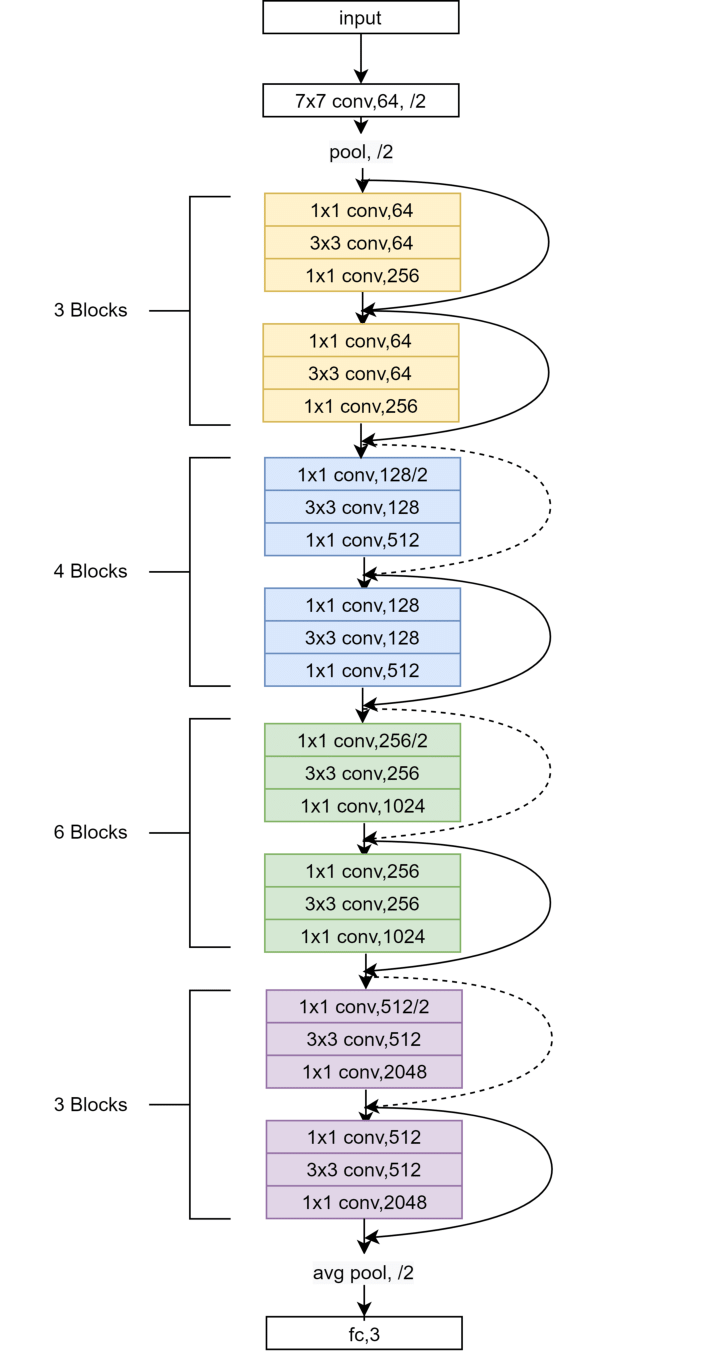

## Training and Testing the model

In [ ]:
# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

In [ ]:
# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs).logits  # .logits for transformers models
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_dataloader)}")

print("Training complete.")

Epoch 1/20, Loss: 1.9785249488694328
Epoch 2/20, Loss: 0.9840859770774841
Epoch 3/20, Loss: 0.7416465026991708
Epoch 4/20, Loss: 0.7263720801898411
Epoch 5/20, Loss: 0.6709414124488831
Epoch 6/20, Loss: 0.8166711671011788
Epoch 7/20, Loss: 0.5487778059073857
Epoch 8/20, Loss: 0.5535232360873904
Epoch 9/20, Loss: 0.44748436978885103
Epoch 10/20, Loss: 0.266557688159602
Epoch 11/20, Loss: 0.8079787109579358
Epoch 12/20, Loss: 0.4330858566931316
Epoch 13/20, Loss: 0.30825528715338024
Epoch 14/20, Loss: 0.13594151607581548
Epoch 15/20, Loss: 0.05162260056074176
Epoch 16/20, Loss: 0.2087598248784031
Epoch 17/20, Loss: 0.4183975106903485
Epoch 18/20, Loss: 0.46150490641593933
Epoch 19/20, Loss: 0.24164657933371408
Epoch 20/20, Loss: 0.15145960450172424
Training complete.


In [ ]:
# Evaluate the model
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).logits
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

In [ ]:
# Calculate metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}")
print(f"Recall: {recall * 100:.2f}")
print(f"F1 Score: {f1 * 100:.2f}")

Accuracy: 60.71%
Precision: 64.29
Recall: 60.71
F1 Score: 58.10


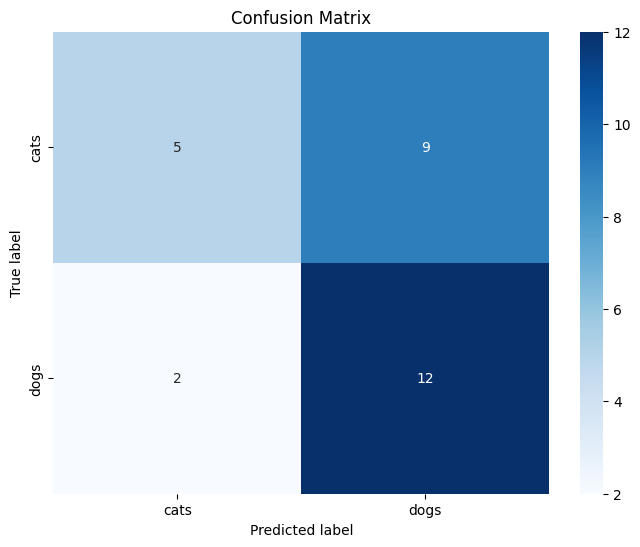

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


## Model on augmented dataset

In [ ]:
# Dataset paths
data_dir = "/content/drive/MyDrive/dataset_augmented"

dataset_augmented = datasets.ImageFolder(root=data_dir, transform=transform)

#add the previous train_dataloader to dataloader_augmented
dataset_augmented = torch.utils.data.ConcatDataset([train_dataset, dataset_augmented])

dataloader_augmented = DataLoader(dataset_augmented, batch_size=16, shuffle=True)

In [ ]:
ones = 0
zeros = 0
for image, label in dataloader_augmented:
    ones += (label == 1).sum().item()
    zeros += (label == 0).sum().item()

print(f"Number of ones: {ones}")
print(f"Number of zeros: {zeros}")

Number of ones: 168
Number of zeros: 168


In [ ]:
config = ResNetConfig.from_pretrained("microsoft/resnet-50")
config.num_labels = len(class_names)  # Set number of output classes
model = ResNetForImageClassification(config)
model.apply(init_weights)

# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

<ipython-input-49-352394a2a408>:3: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  torch.nn.init.xavier_uniform(m.weight.to(device))


ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

In [ ]:
# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in dataloader_augmented:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs).logits  # .logits for transformers models
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(dataloader_augmented)}")


print("Training complete.")

Epoch 1/5, Loss: 0.5931957953032994
Epoch 2/5, Loss: 0.5567878754366011
Epoch 3/5, Loss: 0.41804578119800206
Epoch 4/5, Loss: 0.3971743101165408
Epoch 5/5, Loss: 0.3022292188945271
Training complete.


In [ ]:
# Evaluate the model
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).logits
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

In [ ]:
# Calculate metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}")
print(f"Recall: {recall * 100:.2f}")
print(f"F1 Score: {f1 * 100:.2f}")

Accuracy: 57.14%
Precision: 57.14
Recall: 57.14
F1 Score: 57.14


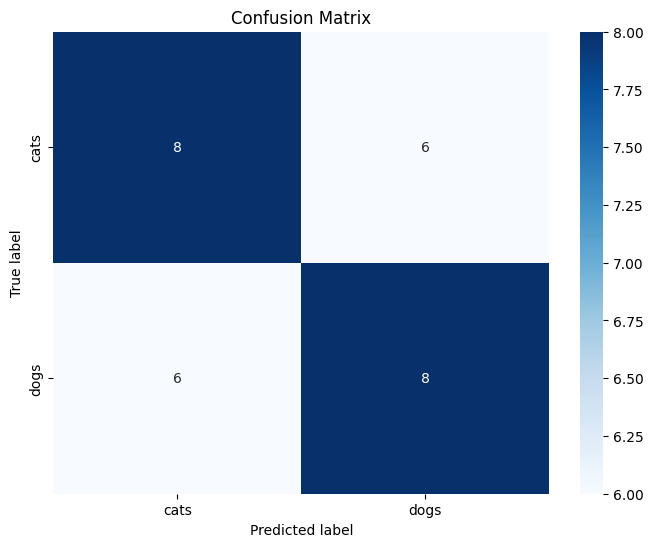

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


### Checking the model on train dataset

In [ ]:
#checking the model on train dataset
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in dataloader_augmented:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).logits
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

In [ ]:
# Calculate metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}")
print(f"Recall: {recall * 100:.2f}")
print(f"F1 Score: {f1 * 100:.2f}")

Accuracy: 94.94%
Precision: 95.07
Recall: 94.94
F1 Score: 94.94


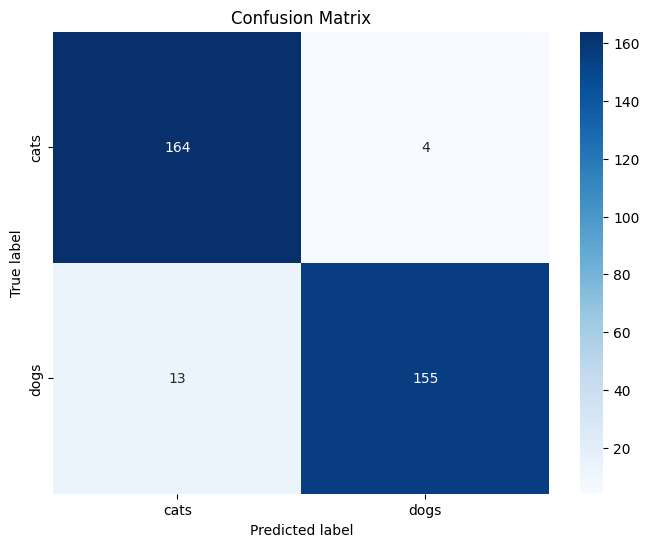

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

- Augmenting the dataset increased the variety of images (e.g., different orientations, scales, lighting conditions), helping the model learn more robust and invariant features rather than memorizing the limited original samples.
- With only 56 training images originally, the model was likely overfitting. Augmentation effectively increased the training set size, which helped in reducing overfitting and improving generalization to the test set.
- As shown above we are getting very high train accuracy on augmented images but less test accuracy which shows that model is tending towards overfitting. But it is performing better than the model with non-augmented images.
- The slight improvement in accuracy indicates that while data augmentation aids learning, the benefits are modest when starting with such a small dataset. The model still faces inherent limitations due to the overall low number of unique real images.